In [1]:
from griblib import CERRA

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [3]:
from plot_defaults import *
from mapplot_defaults import *


In [22]:
### MPL defaults

dpi_fig = 600
base = 13
plt.rcParams.update({
    "font.size": base,
    "axes.labelsize": base,
    "axes.titlesize": base + 1,     # was 13
    "axes.labelpad": 10,            # 12 is fine too
    "xtick.labelsize": base - 2,    # 14
    "ytick.labelsize": base - 2,    # 14
    "legend.fontsize": base - 3,    # 13 (instead of 11)
    "figure.titlesize": base + 2,   # 18 (instead of 14)
})

In [5]:
import cartopy.crs as ccrs
from cartopy.io import shapereader
import cartopy.feature as cfeatures
from cartopy.mpl import ticker as cticker

In [6]:
from pandas import date_range, read_csv, read_excel, to_datetime, to_timedelta
import pandas as pd
import geopandas as gpd

from datetime import datetime
from glob import glob
import numpy as np

### Add geo data (downloaded from PDOK)

In [7]:
# Define GML file paths
gml_files = {
    'provincie': '/Users/assink/Desktop/work/bestuurlijkegrenzen_gml_2021/Provinciegrenzen.gml'
    }

# Read and reproject GML files into a GeoDataFrame dictionary
geo_data = {}
for key, path in gml_files.items():
    gdf = gpd.read_file(path)
    print(f"Read: {key} ({path})")
    geo_data[key] = gdf.to_crs(epsg=4326)

### BORDER DATA ###

# Trigger download and get the shapefile path
shapefile_path = shapereader.natural_earth(
    category='cultural',
    name='admin_0_boundary_lines_land',
    resolution='10m'
)

# Read it and set the CRS manually before reprojecting (if needed)
borders = gpd.read_file(shapefile_path)
borders.set_crs(epsg=4326, inplace=True)  # Add CRS explicitly

# Now you can safely call .to_crs(...) if needed (e.g., to confirm)
borders = borders.to_crs(epsg=4326)

# # Filter for Belgium–Germany border
# geo_data['be_ge_border'] = borders[
#     ((borders['adm0_left'] == 'Belgium') & (borders['adm0_right'] == 'Germany')) |
#     ((borders['adm0_left'] == 'Germany') & (borders['adm0_right'] == 'Belgium'))
# ]
geo_data['borders'] = borders


### COASTLINE DATA ###
# 1. Get shapefile path for coastlines (10m resolution)
coastline_path = shapereader.natural_earth(
    resolution='10m',
    category='physical',
    name='coastline'
)

# 2. Load into GeoDataFrame and assign CRS
coastlines = gpd.read_file(coastline_path)
coastlines.set_crs(epsg=4326, inplace=True)

# 3. Add to geo_data
geo_data['coastline'] = coastlines

Read: provincie (/Users/assink/Desktop/work/bestuurlijkegrenzen_gml_2021/Provinciegrenzen.gml)


In [8]:
my_atmos = CERRA(cycle='43')

## Plotting pressure model parameters

In [27]:
import glob

fid_grib = 'cerra/CERRA_20220630-03.grib'

hPa_level = 950

In [28]:
request = [ {'level_type': 'isobaricInhPa', 'var_list': ['t', 'u', 'v']} ]
ds_raw = my_atmos.read_grib(fid_grib, request, compat='override')
ds_raw

********************************************************************************
Reading CERRA cy43 GRIB file [ cerra/CERRA_20220630-03.grib ]

Reading GRIB PV coefficients
Reading t on isobaricInhPa level
Reading u on isobaricInhPa level
Reading v on isobaricInhPa level


<xarray.Dataset> Size: 416MB
Dimensions:        (isobaricInhPa: 29, y: 1069, x: 1069)
Coordinates:
    time           datetime64[ns] 8B ...
    step           timedelta64[ns] 8B ...
  * isobaricInhPa  (isobaricInhPa) float64 232B 1e+03 975.0 950.0 ... 2.0 1.0
    latitude       (y, x) float64 9MB ...
    longitude      (y, x) float64 9MB ...
    valid_time     datetime64[ns] 8B ...
Dimensions without coordinates: y, x
Data variables:
    t              (isobaricInhPa, y, x) float32 133MB ...
    u              (isobaricInhPa, y, x) float32 133MB ...
    v              (isobaricInhPa, y, x) float32 133MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Norrkoping
    history:                 2026-02-16T21:29 GRIB to CDM+CF via cfgrib-0.9.1...

### Reinterpolate onto regular lat-lon grid

In [29]:
import numpy as np
import xarray as xr
import xesmf as xe

# target lat/lon arrays
lat_new = np.arange(49.5, 54.0, 0.05)
lon_new = np.arange(1.0, 8.0, 0.05)

target_grid = xr.Dataset({
    'latitude': (['latitude'], lat_new),
    'longitude': (['longitude'], lon_new)
})

In [30]:
regridder = xe.Regridder(ds_raw, target_grid, method='bilinear', reuse_weights=False)
ds_reg = regridder(ds_raw)  # returns a new Dataset on regular lat/lon

In [31]:
ds_reg

<xarray.Dataset> Size: 4MB
Dimensions:        (isobaricInhPa: 29, latitude: 90, longitude: 140)
Coordinates:
    time           datetime64[ns] 8B 2022-06-30T03:00:00
    step           timedelta64[ns] 8B 00:00:00
  * isobaricInhPa  (isobaricInhPa) float64 232B 1e+03 975.0 950.0 ... 2.0 1.0
    valid_time     datetime64[ns] 8B 2022-06-30T03:00:00
  * latitude       (latitude) float64 720B 49.5 49.55 49.6 ... 53.85 53.9 53.95
  * longitude      (longitude) float64 1kB 1.0 1.05 1.1 1.15 ... 7.85 7.9 7.95
Data variables:
    t              (isobaricInhPa, latitude, longitude) float32 1MB 285.9 ......
    u              (isobaricInhPa, latitude, longitude) float32 1MB 0.8907 .....
    v              (isobaricInhPa, latitude, longitude) float32 1MB 2.741 ......
Attributes:
    regrid_method:  bilinear

In [32]:
ds = ds_reg.sel(isobaricInhPa=hPa_level)
ds

<xarray.Dataset> Size: 153kB
Dimensions:        (latitude: 90, longitude: 140)
Coordinates:
    time           datetime64[ns] 8B 2022-06-30T03:00:00
    step           timedelta64[ns] 8B 00:00:00
    isobaricInhPa  float64 8B 950.0
    valid_time     datetime64[ns] 8B 2022-06-30T03:00:00
  * latitude       (latitude) float64 720B 49.5 49.55 49.6 ... 53.85 53.9 53.95
  * longitude      (longitude) float64 1kB 1.0 1.05 1.1 1.15 ... 7.85 7.9 7.95
Data variables:
    t              (latitude, longitude) float32 50kB 283.6 283.6 ... 292.1
    u              (latitude, longitude) float32 50kB 8.34 8.396 ... -5.006
    v              (latitude, longitude) float32 50kB 3.67 3.523 ... 7.582 7.52
Attributes:
    regrid_method:  bilinear

In [33]:
valid_time = pd.to_datetime(ds.valid_time.data).strftime('%Y-%m-%d %H:%M:%S')
fid_valid_time = pd.to_datetime(ds.valid_time.data).strftime('%Y-%m-%dT%H%M%S')

print(valid_time, fid_valid_time)

2022-06-30 03:00:00 2022-06-30T030000


### Read radar data

In [34]:
import datetime as dt
import wradlib as wrl
import xarray as xr
import xradar as xd
from osgeo import osr

#filename = '../radar/Herwijnen/data/odim_data/RAD_NL62_VOL_NA_202206300000.odim.h5'
# filename = '../radar/Herwijnen/data/odim_data/RAD_NL62_VOL_NA_202206300100.odim.h5'
# filename = '../radar/Herwijnen/data/odim_data/RAD_NL62_VOL_NA_202206300200.odim.h5'
#filename = '../radar/Herwijnen/data/odim_data/RAD_NL62_VOL_NA_202206300305.odim.h5'
# filename = '../radar/Herwijnen/data/odim_data/RAD_NL62_VOL_NA_202206300340.odim.h5'
#filename = '../radar/Herwijnen/data/odim_data/RAD_NL62_VOL_NA_202206300500.odim.h5'

#filename = '../radar/Herwijnen/data/odim_data/RAD_NL62_VOL_NA_202206300035.odim.h5'
filename = '../radar/Herwijnen/data/odim_data/RAD_NL62_VOL_NA_202206300335.odim.h5'
#filename = '../radar/Herwijnen/data/odim_data/RAD_NL62_VOL_NA_202206300000.odim.h5'
#filename = '../radar/Herwijnen/data/odim_data/RAD_NL62_VOL_NA_202206300300.odim.h5'

#radar = wrl.io.open_odim_dataset(f)
radar = xd.io.open_odim_datatree(filename)
radar_name = 'Herwijnen'

In [35]:
# radar = radar.xradar.georeference()
# radar


proj = osr.SpatialReference()
proj.ImportFromEPSG(32632)
for key in list(radar.children):
    if "sweep" in key:
        radar[key].ds = radar[key].ds.wrl.georef.georeference(crs=proj)

### Great circle path

In [36]:
from griblib.utils.geo import get_great_circle_path

path_params = dict()
path_params['type'] = 'coordinates'
path_params['start'] = dict(lat=50.4, lon=1.0)
path_params['end'] = dict(lat=52.4, lon=6.4)
dr = 1.0

(lons, lats, azi, dist) = get_great_circle_path(path_params, dr)

print(lons, lats)

[1.         1.00001183 1.00002367 ... 6.39997418 6.39998709 6.4       ] [50.4        50.40000486 50.40000972 ... 52.39999142 52.39999571
 52.4       ]


### Wind analysis

In [37]:
ds = my_atmos.compute_wind_speed_and_direction(ds)

/Users/assink/.pixi/envs/default/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1777: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


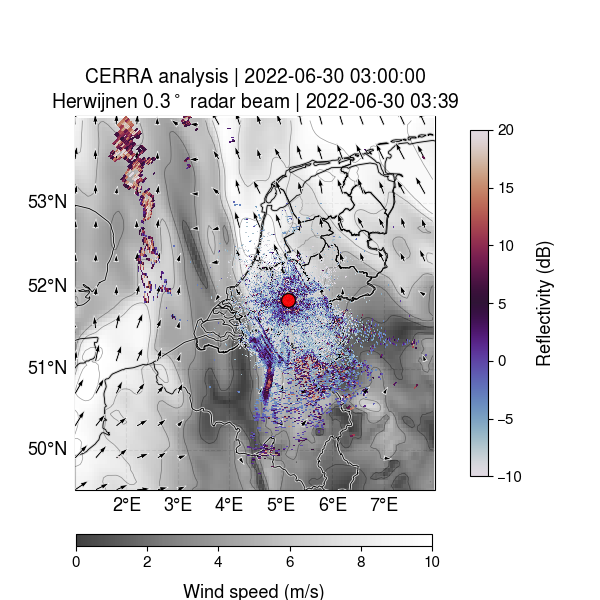

In [38]:
from pandas import to_datetime
from scipy.ndimage import gaussian_filter

projection_map = ccrs.Mercator()

map_extent = [1, 8, 49.5, 54]
(lon_min, lon_max, lat_min, lat_max) = map_extent

db_min = -10
db_max = 20
radar_db_plot = dict(vmin=db_min,
                    vmax=db_max,
                    cmap='twilight')

label_size = 9
annotate_labels = dict(horizontalalignment='center',
                       color=(0.0, 0.0, 0.0, 1.0),
                       size=label_size)
white_stroke = [pe.Stroke(linewidth=3.0, foreground="white"),
                pe.Normal()]
black_stroke = [pe.Stroke(linewidth=2.0, foreground="white"),
                pe.Normal()]

#    if key == 'sweep_15':
#    if "sweep" in key:
for key in list(radar.children):
    if key in ["sweep_15"]:#6", "sweep_14", "sweep_15"]:
        # Extract the cartopy reference system from the radar
        sweep_id = key

        proj_crs = xd.georeference.get_crs(radar[sweep_id].ds)
        cart_crs = ccrs.Projection(proj_crs)

        fig = plt.figure(figsize=(6, 6))
        ax = plt.axes(projection=projection_map)
        ax.set_extent(map_extent, crs=ccrs.PlateCarree())

        ax.add_feature(cfeatures.LAND.with_scale('10m'), color='lightgray', alpha=0.4, zorder=0)  # Light gray for Europe and land
        #ax.add_feature(cfeatures.COASTLINE, linewidth=2.0, alpha=0.7, zorder=1)

        ax.add_feature(cfeatures.LAKES.with_scale('10m'), facecolor='white', edgecolor='black', linewidth=0.5, zorder=4)

        ax.add_feature(cfeature.OCEAN, facecolor='white', zorder=5)

        # Plot each GeoDataFrame in geo_data
        for name, dataset in geo_data.items():
            # Fake shadow: thick, light gray lines underneath
            ax.add_geometries(
                dataset.geometry.values,
                crs=ccrs.PlateCarree(),
                edgecolor='lightgray',
                facecolor='none',
                linewidth=2.0,
                zorder=7
            )

            # Real borders: thinner, darker lines
            ax.add_geometries(
                dataset.geometry.values,
                crs=ccrs.PlateCarree(),
                edgecolor='black',
                facecolor='none',
                linewidth=0.6,
                zorder=8
            )

        #######################################
        # Plot meteo data
        levels = np.linspace(0, 10, 6)  # 0,1,2,...,10
        imw = ds['wind_speed'].plot(ax=ax,
                    x='longitude', y='latitude',
                    vmin=0, vmax=10,
                    cmap='Greys_r',
                    transform=ccrs.PlateCarree(),
                    add_colorbar=False,
                    alpha=0.75,
                    zorder=6)
        # Custom colorbar above the axis
        pos = ax.get_position()
        cbar_ax = fig.add_axes([pos.x0 - 0.015, pos.y0 - 0.02, pos.width*0.8, 0.02])
        cbar = fig.colorbar(imw, ax=ax, cax=cbar_ax, orientation='horizontal')
        cbar.set_label("Wind speed (m/s)")
        cbar.ax.tick_params(labelsize=base - 2)
        
        contours = ax.contour(
            ds.longitude, ds.latitude, ds.wind_speed,
            levels=levels,
            colors='black',
            linewidths=0.5,
            alpha=0.4,
            transform=ccrs.PlateCarree(),
            zorder=7)

        # thin out grid for arrows
        step = 8
        lon_1d = ds['longitude'].values
        lat_1d = ds['latitude'].values
        Lon, Lat = np.meshgrid(lon_1d, lat_1d)

        U = ds['u'].values[::step, ::step]
        V = ds['v'].values[::step, ::step]
        S = ds['wind_speed'].values[::step, ::step]  # same stride

        # Keep only arrows where speed > 2 m/s
        mask = S > 4.0
        X = Lon[::step, ::step][mask]
        Y = Lat[::step, ::step][mask]
        U_plot = U[mask]
        V_plot = V[mask]

        # Quiver plot (on regular grid)
        ax.quiver(
            X, Y, U_plot, V_plot,
            transform=ccrs.PlateCarree(),
            scale=200,
            edgecolor='w',
            width=0.005,
            linewidth=0.5,
            zorder=8
        )

        #######################################
        # Plot radar data
        x = radar[sweep_id]['x']
        y = radar[sweep_id]['y']
        z = radar[sweep_id]["DBZH"].where(
            (radar[sweep_id]["DBZH"] > db_min) & (radar[sweep_id]["DBZH"] < db_max)
            )
        #zf = gaussian_filter(z, sigma=0.3)
        im = ax.pcolormesh(x, y, z, shading='auto', transform=cart_crs, **radar_db_plot, zorder=9)

        cb = plt.colorbar(im, ax=ax, pad=0.075, shrink=0.75, label='Reflectivity (dB)')
        cb.ax.tick_params(labelsize=base - 2)

        ax.scatter(radar['longitude'], radar['latitude'], alpha=0.9, s=100,
                c='red', edgecolor='black', transform=ccrs.PlateCarree(), zorder=10)

        # ax.plot(lons, lats, alpha=0.5, linewidth=0.5, color='red',
        #         transform=ccrs.PlateCarree(), zorder=10,
        #         path_effects=white_stroke)

        # Add gridlines with labels
        gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
        gl.top_labels = False  # Remove top labels
        gl.right_labels = False  # Remove right labels
        gl.xformatter = cticker.LongitudeFormatter()
        gl.yformatter = cticker.LatitudeFormatter()
        

        rtime = to_datetime(radar[sweep_id].time.data[0])
        time_fmt = '%Y-%m-%d %H:%M'
        ftime_fmt = '%Y-%m-%dT%H%M%S'
        radar_str = rf"{radar_name} {radar[sweep_id].elevation.data[0]:.1f}$^\circ$ radar beam | {rtime.strftime(time_fmt)}"
        if my_atmos.model == 'HARMONIE':
            model_type = 'forecast'
        elif my_atmos.model == 'CERRA':
            model_type = 'analysis'
        model_str = rf"{my_atmos.model} {model_type} | {valid_time}"
        ax.set_title(model_str + "\n" + radar_str)

        fid = f'{radar_name}_{rtime.strftime(ftime_fmt)}_{sweep_id}_{my_atmos.model}_{fid_valid_time}_{str(ds.isobaricInhPa.data)}hPa.wind.png'
        fig.savefig(fid, facecolor='white', bbox_inches = 'tight', dpi=dpi_fig)
        # fid = f'{radar_name}_{rtime.strftime(ftime_fmt)}_{sweep_id}_{my_atmos.model}_{fid_valid_time}_{str(ds.isobaricInhPa.data)}hPa.wind.pdf'
        # fig.savefig(fid, facecolor='white', bbox_inches = 'tight', dpi=dpi_fig)
plt.show()

### Temperature analysis

In [39]:
T = ds.t
T_prime = T - T.mean(dim=("latitude", "longitude"))

# fig, ax = plt.subplots(1, 1)
# T_prime.plot(ax=ax, cmap='Greys_r')
# ax.set_title("Temperature perturbation (spatial mean removed)")
# plt.show()

/Users/assink/.pixi/envs/default/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1777: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


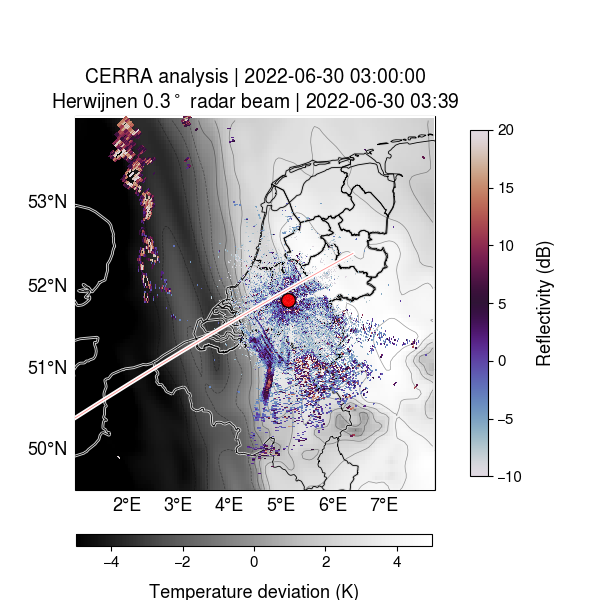

In [40]:
from pandas import to_datetime
from scipy.ndimage import gaussian_filter

projection_map = ccrs.Mercator()

map_extent = [1, 8, 49.5, 54]
(lon_min, lon_max, lat_min, lat_max) = map_extent

db_min = -10
db_max = 20
radar_db_plot = dict(vmin=db_min,
                    vmax=db_max,
                    cmap='twilight')

label_size = 9
annotate_labels = dict(horizontalalignment='center',
                       color=(0.0, 0.0, 0.0, 1.0),
                       size=label_size)
white_stroke = [pe.Stroke(linewidth=3.0, foreground="white"),
                pe.Normal()]
black_stroke = [pe.Stroke(linewidth=2.0, foreground="white"),
                pe.Normal()]

#    if key == 'sweep_15':
#    if "sweep" in key:
for key in list(radar.children):
    if key in ["sweep_15"]:#6", "sweep_14", "sweep_15"]:
        # Extract the cartopy reference system from the radar
        sweep_id = key

        proj_crs = xd.georeference.get_crs(radar[sweep_id].ds)
        cart_crs = ccrs.Projection(proj_crs)

        fig = plt.figure(figsize=(6, 6))
        ax = plt.axes(projection=projection_map)
        ax.set_extent(map_extent, crs=ccrs.PlateCarree())

        ax.add_feature(cfeatures.LAND.with_scale('10m'), color='lightgray', alpha=0.4, zorder=0)  # Light gray for Europe and land
        #ax.add_feature(cfeatures.COASTLINE, linewidth=2.0, alpha=0.7, zorder=1)

        ax.add_feature(cfeatures.LAKES.with_scale('10m'), facecolor='white', edgecolor='black', linewidth=0.5, zorder=4)

        ax.add_feature(cfeature.OCEAN, facecolor='white', zorder=5)

        # Plot each GeoDataFrame in geo_data
        for name, dataset in geo_data.items():
            # Fake shadow: thick, light gray lines underneath
            ax.add_geometries(
                dataset.geometry.values,
                crs=ccrs.PlateCarree(),
                edgecolor='lightgray',
                facecolor='none',
                linewidth=2.0,
                zorder=7
            )

            # Real borders: thinner, darker lines
            ax.add_geometries(
                dataset.geometry.values,
                crs=ccrs.PlateCarree(),
                edgecolor='black',
                facecolor='none',
                linewidth=0.6,
                zorder=8
            )

        #######################################
        # Plot Temperature perturbation data
        levels = np.arange(-5, 5.5, 1)   # bins every 1 K
        # cmap = plt.get_cmap("Greys_r", len(levels)-1)  # discrete version
        # norm = mcolors.BoundaryNorm(levels, cmap.N)
        # imw = T_prime.plot(
        #     ax=ax,
        #     cmap=cmap,
        #     norm=norm,
        #     zorder=6,
        #     transform=ccrs.PlateCarree(),
        #     add_colorbar=False
        # )
        imw = T_prime.plot(
            ax=ax,
            cmap='Greys_r',
            zorder=6,
            vmin=-5, vmax=5,
            transform=ccrs.PlateCarree(),
            add_colorbar=False
        )
        contours = ax.contour(
            ds.longitude, ds.latitude, T_prime,
            levels=levels,
            colors='black',
            linewidths=0.5,
            alpha=0.4,
            transform=ccrs.PlateCarree(),
            zorder=7)

        # Custom colorbar above the axis
        pos = ax.get_position()
        cbar_ax = fig.add_axes([pos.x0 - 0.015, pos.y0 - 0.02, pos.width*0.8, 0.02])
        cbar = fig.colorbar(imw, ax=ax, cax=cbar_ax, orientation='horizontal')
        cbar.set_label(r"Temperature deviation (K)")
        cbar.ax.tick_params(labelsize=base - 2)
        
        #######################################
        # Plot radar data
        x = radar[sweep_id]['x']
        y = radar[sweep_id]['y']
        z = radar[sweep_id]["DBZH"].where(
            (radar[sweep_id]["DBZH"] > db_min) & (radar[sweep_id]["DBZH"] < db_max)
            )
        #zf = gaussian_filter(z, sigma=0.3)
        im = ax.pcolormesh(x, y, z, shading='auto', transform=cart_crs, **radar_db_plot, zorder=9)

        cb = plt.colorbar(im, ax=ax, pad=0.075, shrink=0.75, label='Reflectivity (dB)')
        cb.ax.tick_params(labelsize=base - 2)

        ax.scatter(radar['longitude'], radar['latitude'], alpha=0.9, s=100,
                c='red', edgecolor='black', transform=ccrs.PlateCarree(), zorder=10)

        ax.plot(lons, lats, alpha=0.5, linewidth=0.5, color='red',
                transform=ccrs.PlateCarree(), zorder=10,
                path_effects=white_stroke)

        # Add gridlines with labels
        gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
        gl.top_labels = False  # Remove top labels
        gl.right_labels = False  # Remove right labels
        gl.xformatter = cticker.LongitudeFormatter()
        gl.yformatter = cticker.LatitudeFormatter()

        rtime = to_datetime(radar[sweep_id].time.data[0])
        time_fmt = '%Y-%m-%d %H:%M'
        ftime_fmt = '%Y-%m-%dT%H%M%S'
        radar_str = rf"{radar_name} {radar[sweep_id].elevation.data[0]:.1f}$^\circ$ radar beam | {rtime.strftime(time_fmt)}"
        if my_atmos.model == 'HARMONIE':
            model_type = 'forecast'
        elif my_atmos.model == 'CERRA':
            model_type = 'analysis'
        model_str = rf"{my_atmos.model} {model_type} | {valid_time}"
        ax.set_title(model_str + "\n" + radar_str)

        fid = f'{radar_name}_{rtime.strftime(ftime_fmt)}_{sweep_id}_{my_atmos.model}_{fid_valid_time}_{str(ds.isobaricInhPa.data)}hPa.temp.png'
        fig.savefig(fid, facecolor='white', bbox_inches = 'tight', dpi=dpi_fig)
        # fid = f'{radar_name}_{rtime.strftime(ftime_fmt)}_{sweep_id}_CERRA_{fid_valid_time}_{str(ds.isobaricInhPa.data)}hPa.pdf'
        # fig.savefig(fid, facecolor='white', bbox_inches = 'tight', dpi=dpi_fig)

plt.show()